In [2]:
import math
import sklearn.utils
import sklearn.model_selection
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import seaborn as sns

In [35]:
url = 'https://www.scoreboard.com/ru/football/england/premier-league/results/'
path_browser = 'C:/ProgramData/Anaconda3/Library/bin/chromedriver.exe'

def Scrapping_Web_NBA(url, path_browser):
    
    driver = webdriver.Chrome(path_browser)
    driver.get(url)  # Загружаем ссылку в Chrome
    date, team_1, team_2, score = [], [], [], [] 
    
    while (True):
        try:
            link = driver.find_element_by_link_text('Показать больше матчей')
            link.click()
            time.sleep(5)
        except NoSuchElementException:
            break
        
    #p_element = driver.find_elements_by_class_name(name='padr')
    for element in driver.find_elements_by_css_selector(".cell_ad.time"): 
        date.append(element.text)
        
    for element in driver.find_elements_by_css_selector(".cell_ab.team-home"): # Парсим по уникальному классу classy
        team_1.append(element.text)
    
    for element in driver.find_elements_by_css_selector(".padl"): 
        team_2.append(element.text)
   
    
    for element in driver.find_elements_by_css_selector(".cell_sa.score.bold"): 
        score.append(element.text)
    

    driver.close()
    
    columns  = ['date', 'Team 1(Home)', 'Team 2', 'Score'] # Названия столбцов
    data = pd.DataFrame(columns = columns)
    data['date'] = date # дата матча
    data['Team 1(Home)'] = team_1 # команда 1(играет дома)
    data['Team 2'] = team_2[1::2] # команда 2
    data['Score'] = score # счет
    data['Team 1(Home)'] = data['Team 1(Home)'].str.strip(' ')     # Убираем пробелы в конце названия команд, чтобы выделить уникальные
    data['Team 2'] = data['Team 2'].str.strip(' ')
    cam1 = data['Team 1(Home)'].unique()
    cam2 = data['Team 2'].unique()
    cam1, cam2 = list(cam1), list(cam2)
    cam = list(set(cam1 + cam2))
    cam.sort()
    count_team = len(cam) # Число команд
    b = np.arange(1, count_team + 1, 1)
    dicts = dict(zip(cam, b)) # Каждой команде присваиваем номер
    
    for index in data.index:
        if (data['Score'][index].find("\n") != -1):
            pos1 = data['Score'][index].find("\n")
            data['Score'][index] = data['Score'][index][:pos1:]
        position = str(data['Score'][index]).find(':')
        m = int(data['Score'][index][:position - 1]) - int(data['Score'][index][position + 2:])
        data['Score'][index] = m
    
    data = data.replace(cam, b)       # Заменяем название команды на цифру

    df = data.iloc[::-1]      # Переворачиваем таблицу, чтобы в начале таблицы были прошедшие матчи
    df.index = df.index.sort_values()  # Присваиваем новые индексы
    df = df.drop(['date'], axis='columns')
    
    
    norm = np.mean(df['Score'])
    df['Score'] = df['Score']/norm


    return df, dicts, count_team






def SVD_train_NBA(df, train_data, test_data, count_team, number_factors=105, n_iteration=61): 
    
    #count_team = len(np.unique(df['Team 1(Home)'])) # Число команд
    global_mean_raiting = train_data['Score'].mean() # Средний показатель
    
    #number_factors = 50                  # Количество факторов, которые будут задавать размер векторов pu[u,f] и qi[i,f
    eta_rate = .005                      # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и eta 
    lambda_rate = .02                 # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и etc
    #n_iteration = 20                 # Число итераций SGD
    
    np.random.seed(seed=1)
    init_mean = 0 
    init_std_dev = .1
    p = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors))# (0 iteration) Массив признаков пользователей, размер [n*f], где n- количество юзеров, f- количество факторовq = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    q = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    p = np.array(p, dtype='float64')
    q = np.array(q, dtype='float64')
    bi = np.zeros(count_team + 1, np.double) # bias of items
    bu = np.zeros(count_team + 1, np.double) # bias of users

    # Обучение модели
    for k in range(n_iteration):        # Цикл для итераций
        for ind in train_data.index:
            u = int(train_data.iloc[ind, 0])   # Команда 1
            i = int(train_data.iloc[ind, 1])   # Команда 2
            r = float(train_data.iloc[ind, 2])   # Счет Команда1:Команда2 
            dot = np.dot(p[u], q[i])      # (q_i, p_u) - скалярное умножение
        
                    
            predict_r = global_mean_raiting + bu[u] + bi[i] + dot   # r_ui с крышкой
            e_ui = r - predict_r
        
        
            #Обновляем вектора pu, qi, bu, bi
            p[u] += eta_rate * (e_ui * q[i] - lambda_rate * p[u])
            q[i] += eta_rate * (e_ui * p[u] - lambda_rate * q[i])
            bi[i] += eta_rate * (e_ui - lambda_rate * bi[i])
            bu[u] += eta_rate * (e_ui - lambda_rate * bu[u])
            
    return global_mean_raiting, p, q, bi, bu


def SVD_test_NBA(data, global_mean_raiting, p, q, bi, bu):
    
    data.index = np.arange(0, len(data), 1) # Записываем индексы от 0
    R_predict = []
    for ind in data.index:
        u = data.iloc[ind, 0]   # Команда 1(домашняя)
        i = data.iloc[ind, 1]   # Команда 2
        r = data.iloc[ind, 2]   # Счет
        
        dot = np.dot(p[u], q[i]) 
        predict_r = global_mean_raiting + bu[u] + bi[i] + dot
        R_predict.append(predict_r)
    return R_predict    

def SVD_train_pp(df, train_data, test_data, count_team, number_factors=105, n_iteration=61): 
    
    #count_team = df['Team 1(Home)'].max() # Число команд
    global_mean_raiting = train_data['Score'].mean() # Средний показатель
    
    #number_factors = 50                  # Количество факторов, которые будут задавать размер векторов pu[u,f] и qi[i,f
    eta_rate = .003                      # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и eta 
    lambda_rate = .02                 # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и etc
    #n_iteration = 20                 # Число итераций SGD
    
    np.random.seed(seed=1)
    init_mean = 0 
    init_std_dev = .1
    p = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors))# (0 iteration) Массив признаков пользователей, размер [n*f], где n- количество юзеров, f- количество факторовq = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    q = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    yj = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (count_item, number_factors)
    p = np.array(p, dtype='float64')
    q = np.array(q, dtype='float64')
    bi = np.zeros(count_team + 1, np.double) # bias of items
    bu = np.zeros(count_team + 1, np.double) # bias of users

    # Обучение модели
    for k in range(n_iteration):        # Цикл для итераций
        for ind in train_data.index:
            
            
            u = int(train_data.iloc[ind, 0])   # Команда 1
            i = int(train_data.iloc[ind, 1])   # Команда 2
            r = float(train_data.iloc[ind, 2])   # Счет Команда1:Команда2 
            
            sum_yj = 0
            I_u = train_data[train_data['Team 1(Home)'] == u] # Все команды, с которыми играла команда u
            card_I_u = np.sqrt(len(I_u))   # Количество этих команд
            
            
            for j in I_u['Team 2']:
                sum_yj += yj[j] # Учитываем только те команды, с которыми играла данная
                    
            
            
            dot = np.dot(p[u] + 1/card_I_u * sum_yj , q[i])      # (q_i, p_u) - скалярное умножение
        

            
                    
            predict_r = global_mean_raiting + bu[u] + bi[i] + dot   # r_ui с крышкой
            e_ui = r - predict_r
        
            
            #Обновляем вектора pu, qi, bu, bi
            p[u] += eta_rate * (e_ui * q[i] - lambda_rate * p[u])
            q[i] += eta_rate * (e_ui * (p[u] + 1/card_I_u * sum_yj) - lambda_rate * q[i])
            bi[i] += eta_rate * (e_ui - lambda_rate * bi[i])
            bu[u] += eta_rate * (e_ui - lambda_rate * bu[u])
            
            for j in I_u['Team 2']:
                yj[j] += eta_rate * (e_ui * 1/card_I_u * q[i] - lambda_rate * yj[j])
                                
                        
            
    return global_mean_raiting, p, q, bi, bu, yj


def SVD_test_pp(data, global_mean_raiting, p, q, bi, bu, yj):
    
    data.index = np.arange(0, len(data), 1) # Записываем индексы от 0
    R_predict = []
    for ind in data.index:
        u = data.iloc[ind, 0]   # Команда 1(домашняя)
        i = data.iloc[ind, 1]   # Команда 2
        r = data.iloc[ind, 2]   # Счет
        
        sum_yj = 0
            
        I_u = train_data[train_data['Team 1(Home)'] == u] # Все команды, с которыми играла команда u
        card_I_u = np.sqrt(len(I_u))   # Количество этих команд
        for j in I_u['Team 2']:
            sum_yj += yj[j]     # Учитываем только те команды, с которыми играла данная
                                
        dot = np.dot(p[u] + 1/card_I_u * sum_yj , q[i])  
        predict_r = global_mean_raiting + bu[u] + bi[i] + dot
        R_predict.append(predict_r)
    return R_predict    


def SVD_train_pp_double(df, train_data, test_data, count_team, number_factors=20, n_iteration=20): 
    
    #count_team = df['Team 1(Home)'].max() # Число команд
    global_mean_raiting = train_data['Score'].mean() # Средний показатель
    
    #number_factors = 50                  # Количество факторов, которые будут задавать размер векторов pu[u,f] и qi[i,f
    eta_rate = .005                      # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и eta 
    lambda_rate = .01                 # Коэффициент для p_u<-p_u+eta_rate(e_ui*qi-lambda_rate*pu) и etc
    #n_iteration = 20                 # Число итераций SGD
    
    np.random.seed(seed=1)
    init_mean = 0 
    init_std_dev = .2
    p = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors))# (0 iteration) Массив признаков пользователей, размер [n*f], где n- количество юзеров, f- количество факторовq = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    q = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (0 itaretion)Массив признаков фильмов, размер [m*f], где m- количество фильмов, f- количество факторов
    yj = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors)) # (count_item, number_factors)
    xi = np.random.normal(init_mean, init_std_dev, (count_team + 1, number_factors))
    p = np.array(p, dtype='float64')
    q = np.array(q, dtype='float64')
    yj = np.array(yj, dtype='float64')
    xi = np.array(xi, dtype='float64')
    bi = np.zeros(count_team + 1, np.double) # bias of items
    bu = np.zeros(count_team + 1, np.double) # bias of users

    # Обучение модели
    for k in range(n_iteration):        # Цикл для итераций
        for ind in train_data.index:
            
            u = int(train_data.iloc[ind, 0])   # Команда 1
            i = int(train_data.iloc[ind, 1])   # Команда 2
            r = float(train_data.iloc[ind, 2])   # Счет Команда1:Команда2 
            
            sum_yj = 0
            I_u = train_data[train_data['Team 1(Home)'] == u] # Все команды, с которыми играла команда u
            card_I_u = np.sqrt(len(I_u))   # Количество этих команд
            
            sum_xi = 0
            N_u = train_data[train_data['Team 2'] == i] # Все команды, с которыми играла команда u
            card_N_u = np.sqrt(len(N_u))   # Количество этих команд
            
            for j in I_u['Team 2']:
                sum_yj += yj[j] # Учитываем только те команды, с которыми играла данная
                    
            for i in N_u['Team 1(Home)']:
                sum_xi += xi[i] # Учитываем только те команды, с которыми играла данная
            
            dot = np.dot(p[u] + 1/card_I_u * sum_yj , q[i] + 1/card_N_u * sum_xi)      # (q_i, p_u) - скалярное умножение
        
            
                    
            predict_r = global_mean_raiting + bu[u] + bi[i] + dot   # r_ui с крышкой
            e_ui = r - predict_r
        
            
            #Обновляем вектора pu, qi, bu, bi
            p[u] += eta_rate * (e_ui * (q[i] + 1/card_N_u * sum_xi)- lambda_rate * p[u])
            q[i] += eta_rate * (e_ui * (p[u] + 1/card_I_u * sum_yj) - lambda_rate * q[i])
            bi[i] += eta_rate * (e_ui - lambda_rate * bi[i])
            bu[u] += eta_rate * (e_ui - lambda_rate * bu[u])
            
            for j in I_u['Team 2']:
                yj[j] += eta_rate * (e_ui * 1/card_I_u * (q[i] + 1/card_N_u * sum_xi) - lambda_rate * yj[j])
            
            for i in N_u['Team 1(Home)']:
                xi[i] += eta_rate * (e_ui * 1/card_N_u * (p[u] + 1/card_I_u * sum_yj) - lambda_rate * xi[i])
                                
                        
            
    return global_mean_raiting, p, q, bi, bu, yj, xi


def SVD_test_pp_double(data, global_mean_raiting, p, q, bi, bu, yj, xi):
    
    data.index = np.arange(0, len(data), 1) # Записываем индексы от 0
    R_predict = []
    for ind in data.index:
        u = data.iloc[ind, 0]   # Команда 1(домашняя)
        i = data.iloc[ind, 1]   # Команда 2
        r = data.iloc[ind, 2]   # Счет
        
        sum_yj = 0
            
        I_u = train_data[train_data['Team 1(Home)'] == u] # Все команды, с которыми играла команда u
        card_I_u = np.sqrt(len(I_u))   # Количество этих команд
        for j in I_u['Team 2']:
            sum_yj += yj[j]     # Учитываем только те команды, с которыми играла данная
            
        sum_xi = 0
        N_u = train_data[train_data['Team 2'] == i] # Все команды, с которыми играла команда u
        card_N_u = np.sqrt(len(N_u))   # Количество этих команд
            
        for i in N_u['Team 1(Home)']:
            sum_xi += xi[i] # Учитываем только те команды, с которыми играла данная
        
                                
        dot = np.dot(p[u] + 1/card_I_u * sum_yj , q[i] + 1/card_N_u * sum_xi)  
        predict_r = global_mean_raiting + bu[u] + bi[i] + dot
        R_predict.append(predict_r)
    return R_predict    


def check_score(score):
    if score > 0:
        win = 1
    if score < 0:
        win = -1
    if score == 0:
        win = 0
    return win

def accucary(predict_data, test_data):
    summ = 0
    for index in test_data.index:
        score1_predict = predict_data[index]
        score1_real = int(test_data['Score'][index])
        if check_score(score1_predict) == check_score(score1_real):
            summ += 1
    return summ/len(test_data)

def show_efficient(R_predict_train, train_data, R_predict_test, test_data):
    print ('Эффективность на обучающей выборке=', accucary(R_predict_train, train_data),\
           'Эффективность на тест выборке=', accucary(R_predict_test, test_data))

def find_best_parameters (df, train_data, list_factors, list_iteration):

    best_values_train = 0

    for it in list_iteration:
        for f in list_factors:
            global_mean_raiting, p, q, bi, bu = SVD_train(df, train_data, test_data, f, it)
            R_predict_train = SVD_test(train_data, global_mean_raiting, p, q, bi, bu)
            ef_train = accucary(R_predict_train, train_data)
            if (best_values_train == 0):
                best_values_train = ef_train
            if (ef_train > best_values_train):
                #print(best_values_train)
                pos_f, pos_it = f, it
                best_values_train = ef_train
                
    return best_values_train, pos_f, pos_it

In [13]:
path_browser = 'C:/ProgramData/Anaconda3/Library/bin/chromedriver.exe'
url6 = 'https://www.myscore.ru/basketball/usa/nba/results/'
#df, dicts, count_team = Scrapping_Web_NBA(url6, path_browser) # Получили базу
train_data, test_data = sklearn.model_selection.train_test_split(df,\
                                                                  test_size=0.25, shuffle=False) # Отношение train=75%, test=25%

global_mean_raiting, p, q, bi, bu = SVD_train_NBA(df, train_data, test_data, count_team, number_factors=105, n_iteration=160)
R_predict_train = SVD_test_NBA(train_data, global_mean_raiting, p, q, bi, bu)
R_predict_test = SVD_test_NBA(test_data, global_mean_raiting, p, q, bi, bu)
show_efficient(R_predict_train, train_data, R_predict_test, test_data)

Эффективность на обучающей выборке= 0.8154463390170511 Эффективность на тест выборке= 0.5795795795795796


In [52]:
df['Score'] = df['Score'].round()
train_data, test_data = sklearn.model_selection.train_test_split(df,\
                                                                 test_size=0.1, shuffle=False) # Отношение train=75%, test=25%


global_mean_raiting, p, q, bi, bu = SVD_train_NBA(df, train_data, test_data, count_team, number_factors=105, n_iteration=120)
R_predict_train1 = SVD_test_NBA(train_data, global_mean_raiting, p, q, bi, bu)
R_predict_test1 = SVD_test_NBA(test_data, global_mean_raiting, p, q, bi, bu)
show_efficient(R_predict_train1, train_data, R_predict_test1, test_data)
acc1 = accucary(R_predict_test1, test_data)

global_mean_raiting, p, q, bi, bu, yj = SVD_train_pp(df, train_data, test_data, count_team, number_factors=60, n_iteration=40)
R_predict_train2 = SVD_test_pp(train_data, global_mean_raiting, p, q, bi, bu, yj)
R_predict_test2 = SVD_test_pp(test_data, global_mean_raiting, p, q, bi, bu, yj)
show_efficient(R_predict_train2, train_data, R_predict_test2, test_data)
acc2 = accucary(R_predict_test2, test_data)


global_mean_raiting, p, q, bi, bu, yj, xi = SVD_train_pp_double(df, train_data, test_data, count_team, number_factors=40, n_iteration=50)
R_predict_train3 = SVD_test_pp_double(train_data, global_mean_raiting, p, q, bi, bu, yj, xi)
R_predict_test3 = SVD_test_pp_double(test_data, global_mean_raiting, p, q, bi, bu, yj, xi)
show_efficient(R_predict_train3, train_data, R_predict_test3, test_data)
acc3 = accucary(R_predict_test3, test_data)

Эффективность на обучающей выборке= 0.8521303258145363 Эффективность на тест выборке= 0.5488721804511278
Эффективность на обучающей выборке= 0.8295739348370927 Эффективность на тест выборке= 0.5263157894736842
Эффективность на обучающей выборке= 0.7309941520467836 Эффективность на тест выборке= 0.5037593984962406


In [50]:
len(R_predict_test2)

40

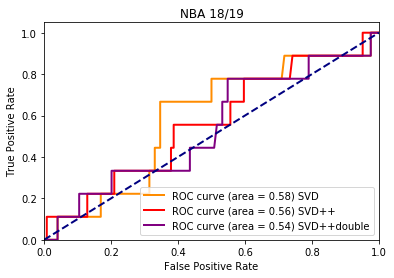

In [53]:
from sklearn import metrics
score_test, score_real = [], []
fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(test_data['Score']), np.array(R_predict_test1), pos_label=2)
fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(test_data['Score']), np.array(R_predict_test2), pos_label=2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(test_data['Score']), np.array(R_predict_test3), pos_label=2)
lw = 2
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
roc_auc3 = metrics.auc(fpr3, tpr3)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) SVD' % roc_auc1)
plt.plot(fpr2, tpr2, color='red',
         lw=lw, label='ROC curve (area = %0.2f) SVD++' % roc_auc2)
plt.plot(fpr3, tpr3, color='purple',
         lw=lw, label='ROC curve (area = %0.2f) SVD++double' % roc_auc3)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NBA 18/19')
plt.legend(loc="lower right") 
plt.show()